#### This notebook presents how to perform maximum-likelihood parameter estimation for a single neuron.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
%matplotlib inline

In [2]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(),".."))
sys.path.append(os.path.join(os.getcwd(),"..","code"))
data_path = os.path.join(os.getcwd(),"..",'data')
sys.path.append(data_path)

In [3]:
import filters
import likelihood_functions as lk
import PoissonProcessClasses as PP
import auxiliary_functions as auxfun

In [4]:
# Reloading modules which are in development
import imp
imp.reload(filters)
imp.reload(auxfun)
imp.reload(lk)
imp.reload(PP)

<module 'PoissonProcessClasses' from '/Users/val/MEGAsync/GLM_PythonModules/notebooks/../code/PoissonProcessClasses.py'>

Reading input-output data:

In [5]:
# reading stimulus
Stim = np.array(pd.read_csv(os.path.join(data_path,'Stim.csv'),header = None))
# reading location of spikes
tsp = np.hstack(np.array(pd.read_csv(os.path.join(data_path,'tsp.csv'),header = None)))

Extracting a spike train from spike positions:

In [6]:
dt = 0.01
tsp_int = np.ceil((tsp - dt*0.001)/dt)
tsp_int = np.reshape(tsp_int,(tsp_int.shape[0],1))
tsp_int = tsp_int.astype(int)
y = np.array([item in tsp_int for item in np.arange(Stim.shape[0]/dt)+1]).astype(int)

Displaying a subset of the spike train:

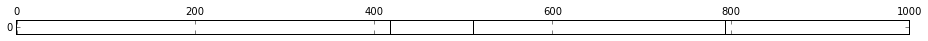

In [7]:
fig, ax = plt.subplots(figsize=(16, 2))
fig = ax.matshow(np.reshape(y[:1000],(1,len(y[:1000]))),cmap = 'Greys',aspect = 15)

Creating filters:

In [8]:
# create a stimulus filter
kpeaks = np.array([0,round(20/3)])
pars_k = {'neye':5,'n':5,'kpeaks':kpeaks,'b':3}
K,K_orth,kt_domain = filters.createStimulusBasis(pars_k, nkt = 20) 

In [9]:
# create a post-spike filter
hpeaks = np.array([0.1,2])
pars_h = {'n':5,'hpeaks':hpeaks,'b':.4,'absref':0.}
H,H_orth,ht_domain = filters.createPostSpikeBasis(pars_h,dt)

In [10]:
# Interpolate Post Spike Filter
MSP = auxfun.makeInterpMatrix(len(ht_domain),1)
MSP[0,0] = 0
H_orth = np.dot(MSP,H_orth)

(2,)
(486, 486)


In [11]:
MSP.shape

(486, 486)

*Conditional Intensity* (spike rate):

$$\lambda_{\beta} = \exp(K(\beta_k)*Stim + H(\beta_h)*y + dc)$$

($\beta_k$ and $\beta_h$ are the unknown coefficients of the filters and $dc$ is the direct current).

Since the convolution is a linear operation the intensity can be written in the following form:

$$\lambda_{\beta} = \exp(M_k \beta_k + M_h\beta_h + \textbf{1}dc),$$

where $M_k$ and $M_h$ are matrices depending on the stimulus and the response correspondingly and $\textbf{1}$ is a vector of ones.

Creating a matrix of covariates:

In [12]:
M_k = lk.construct_M_k(Stim,K,dt)

In [13]:
M_h = lk.construct_M_h(tsp,H_orth,dt,Stim)

Combining $M_k$, $M_h$ and $\textbf{1}$ into one covariate matrix:

In [14]:
M = np.hstack((M_k,M_h,np.ones((M_h.shape[0],1))))

The conditional intensity becomes:
$$ \lambda_{\beta} = \exp(M\beta) $$

($\beta$ contains all the unknown parameters).

Create a Poisson process model with this intensity:

In [15]:
model = PP.PPModel(M.T,dt = dt/100)

Setting initial parameters for optimization:

In [16]:
coeff_k0 = np.array([-0.02304,
   0.12903,
   0.35945,
   0.39631,
   0.27189,
   0.22003,
  -0.17457,
   0.00482,
  -0.09811,
   0.04823])
coeff_h0 = np.zeros((5,))
dc0 = 0

pars0 = np.hstack((coeff_k0,coeff_h0,dc0))

In [17]:
# pars0 = np.hstack((np.zeros((10,)),np.ones((5,)),0))

Fitting the likelihood (here using Limited Memory BFGS method with 500 iterations):

In [18]:
res = model.fit(y,start_coef = pars0,maxiter = 500,method = 'L-BFGS-B')

-389.09828112
-1371.83034726
273841.02813
-1618.47383527
-1662.80305679
-1186.54105026
-1790.30108482
-1873.08211713
-1923.51526402
-1955.66643226
-1997.71741105
-2024.69276077
-2036.65395162
-2040.12838983
-2043.61678464
-2048.564233
-2054.77501312
-2071.33859401
-2108.09463066
-2161.68744978
-2250.96307752
-2322.86549294
-2389.22303221
-2366.66813707
-2403.26031904
-2417.66550327
-2428.8369058
-2448.1148988
-2479.28621294
-2528.90692195
-2513.75713527
-2544.03635611
-2554.98728472
-2557.40523849
-2558.69013435
-2560.37624644
-2559.74938385
-2560.80156666
-2561.26020304
-2561.56490122
-2561.80868238
-2562.39125944
-2563.43379348
-2564.72111833
-2566.22047037
-2567.44056538
-2569.21843472
-2572.01096182
-2569.49245482
-2573.92307356
-2577.62142258
-2581.42373597
-2586.48112564
-2592.27051534
-2595.53465805
-2598.88749007
-2599.96924845
-2601.08820727
-2601.9151204
-2603.38811719
-2604.26326276
-2605.27384205
-2607.52175411
-2600.29251498
-2608.77383571
-2611.64404424
-2613.63098266
-26

/Users/val/MEGAsync/GLM_PythonModules/notebooks/../code/PoissonProcessClasses.py:169: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if start_coef==None:
/Users/val/anaconda/lib/python3.4/site-packages/scipy/optimize/_minimize.py:362: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  RuntimeWarning)
/Users/val/MEGAsync/GLM_PythonModules/notebooks/../code/PoissonProcessClasses.py:171: OptimizeWarning: Unknown solver options: maxfev
  res = optimize.minimize(self.negLogL,start_coef,jac = self.gradNegLogL,hess = self.hessNegLogL, args = y, options = opts, method = method)


Optimization results:

In [19]:
print(res)

     nit: 303
  status: 0
 message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     fun: -2622.0531807765924
     jac: array([ 0.02454943, -0.02685258, -0.02488868, -0.00412308, -0.01858206,
        0.03924595,  0.16784614,  0.21752727,  0.13450727,  0.00195742,
       -0.01022792, -0.00494685, -0.0183314 ,  0.02328966,  0.01133687,
       -0.00944875])
    nfev: 329
       x: array([  4.37068505e-02,   2.57996778e-01,   8.88368183e-01,
         1.24323609e+00,   9.56581074e-01,   4.63212194e-01,
        -8.40953345e-01,  -2.09171826e-03,   7.39851459e-02,
        -1.23367823e-01,  -1.82937408e+01,   6.08852195e+01,
        -1.02165778e+02,  -3.89551012e+01,  -1.01257541e+01,
         2.91769697e+00])
 success: True


Creating the predicted filters:

In [20]:
k_coeff_predicted = res.x[:10]
h_coeff_predicted = res.x[10:15]

In [21]:
kfilter_predicted = np.dot(K,k_coeff_predicted)
hfilter_predicted = np.dot(H_orth,h_coeff_predicted)

In [22]:
k_coeff = np.array([ 0.061453,0.284916,0.860335,1.256983,0.910615,0.488660,-0.887091,0.097441,0.026607,-0.090147])
h_coeff = np.array([-15.18,38.24,-67.58,-14.06,-3.36])

kfilter_true = np.dot(K,k_coeff)
hfilter_true = np.dot(H_orth,h_coeff)

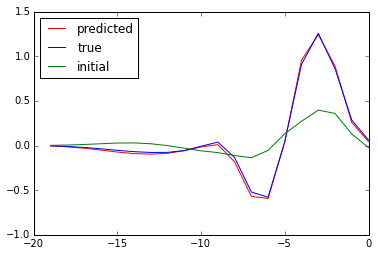

In [23]:
plt.plot(-kt_domain[::-1],kfilter_predicted,color = "r",label = 'predicted')
plt.hold(True)
plt.plot(-kt_domain[::-1],kfilter_true,color= "blue",label = 'true')
plt.hold(True)
plt.plot(-kt_domain[::-1],np.dot(K,coeff_k0),color = "g",label = 'initial')
plt.legend(loc = 'upper left')

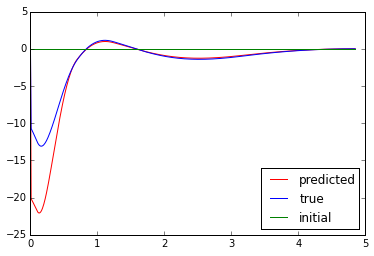

In [24]:
plt.plot(ht_domain,hfilter_predicted,color = "r",label = 'predicted')
plt.hold(True)
plt.plot(ht_domain,hfilter_true,color = "b",label = 'true')
plt.hold(True)
plt.plot(ht_domain,np.dot(H_orth,coeff_h0),color = "g",label = 'initial')
plt.legend(loc = 'lower right')